### Inline Example of Local Expert 'Optimal Interpolation' on Satellite Data


# Using Colab? Then clone and install

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import subprocess
    import os
    import re

    # change to working directory
    work_dir = "/content"

    assert os.path.exists(work_dir), f"workspace directory: {work_dir} does not exist"
    os.chdir(work_dir)

    # clone repository
    command = "git clone https://github.com/CPOMUCL/GPSat.git"
    result = subprocess.run(command.split(), capture_output=True, text=True)
    print(result.stdout)

    repo_dir = os.path.join(work_dir, "GPSat")

    print(f"changing directory to: {repo_dir}")
    os.chdir(repo_dir)

    # exclude certain requirements if running on colab - namely avoid installing/upgrading tensorflow
    new_req = []
    with open(os.path.join(repo_dir, "requirements.txt"), "r") as f:
        for line in f.readlines():
            # NOTE: here also removing numpy requirement
            if re.search("^tensorflow|^numpy", line):
                new_req.append("#" + line)
            else:
                new_req.append(line)

    # create a colab specific requirements file
    with open(os.path.join(repo_dir, "requirements_colab.txt"), "w") as f:
        f.writelines(new_req)

    # install the requirements
    command = "pip install -r requirements_colab.txt"
    with subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True) as proc:
        # Stream the standard output in real-time
        for line in proc.stdout:
            print(line, end='')

    # install the GPSat pacakge in editable mode
    command = "pip install -e ."
    with subprocess.Popen(command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True) as proc:
        # Stream the standard output in real-time
        for line in proc.stdout:
            print(line, end='')

#  Import Packages

In [2]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from global_land_mask import globe
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.dataloader import DataLoader
from GPSat.utils import stats_on_vals, WGS84toEASE2, EASE2toWGS84, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_wrapper, plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data, plot_hyper_parameters
from GPSat.postprocessing import smooth_hyperparameters

2024-08-28 21:14:41.180697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 21:14:41.180746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 21:14:41.181755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 21:14:41.187550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-08-28 21:14:42.112275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Parameters

In [3]:

# NOTE: there are parameters values that are set inline in the cells below

# lat,lon center (origin) used for converting between WGS84 and EASE2 projections
lat_0 = 90
lon_0 = 0

# expert location parameters
# spacing between experts (laid out on a grid), in meters
expert_spacing = 200_000
# range of experts, from origin, in meters
# expert_x_range = [-750_000.0, 1000_000.0]
# expert_y_range = [-500_000.0, 1250_000.0]
expert_x_range = [-500_000, 500_000]
expert_y_range = [-500_000, 500_000]

# prediction spacing
# (below predictions same range as experts)
pred_spacing = 5_000


# model parameters
# Set training and inference radius
# - distance observations need to be away from expert locations to be included in training
training_radius = 300_000  # 300km
# - distance prediction locations need to be away from expert locations in order of predictions to be made
inference_radius = 200_000  # 200km


# plotting
# extent = [lon min, lat max, lat min, lat max]
extent = [-180, 180, 60, 90]

# which projection to use: "north" or "south"
projection = "north"

#  read in raw data

add each key in col_func as a column, using a specified function + arguments
values are unpacked and passed to GPSat.utils.config_func

In [4]:


df = DataLoader.read_flat_files(file_dirs=get_data_path("example"),
                                file_regex="_RAW\.csv$",
                                col_funcs={
                                    "source": {
                                        "func": lambda x: re.sub('_RAW.*$', '', os.path.basename(x)),
                                        "filename_as_arg": True
                                    }
                                })

# convert lon, lat, datetime to x, y, t - to be used as the coordinate space
df['x'], df['y'] = WGS84toEASE2(lon=df['lon'], lat=df['lat'], lat_0=lat_0, lon_0=lon_0)
df['t'] = df['datetime'].values.astype("datetime64[D]").astype(float)

----------------------------------------------------------------------------------------------------
reading files from:
/home/runner/work/GPSat/GPSat/data/example/
that match regular expression: _RAW\.csv$


'read_from_multiple_files': 0.826 seconds


# stats on data

In [5]:

print("*" * 20)
print("summary / stats table on metric (use for trimming)")

val_col = 'z'
vals = df[val_col].values
stats_df = stats_on_vals(vals=vals, name=val_col,
                         qs=[0.01, 0.05] + np.arange(0.1, 1.0, 0.1).tolist() + [0.95, 0.99])

print(stats_df)

********************
summary / stats table on metric (use for trimming)


'stats_on_vals': 0.234 seconds
                      z
measure               z
size            1174848
num_not_nan     1174848
num_inf               0
min            -16.7965
mean           0.128416
max             16.7093
std            0.186566
skew         -10.912819
kurtosis     890.268297
q0.010          -0.3732
q0.050          -0.1387
q0.100          -0.0485
q0.200           0.0322
q0.300           0.0767
q0.400           0.1101
q0.500           0.1394
q0.600           0.1686
q0.700           0.2011
q0.800           0.2424
q0.900           0.3067
q0.950           0.3632
q0.990           0.4775


# visualise data

'stats_on_vals': 0.287 seconds
there were too many points 1174848>max_obs: 500000
selecting 42.56% (500046) points at random for raw data plot
plotting pcolormesh...


'plot_pcolormesh': 0.142 seconds
plotting hist (using all data)...


'plot_hist': 2.055 seconds
'plot_wrapper': 2.679 seconds


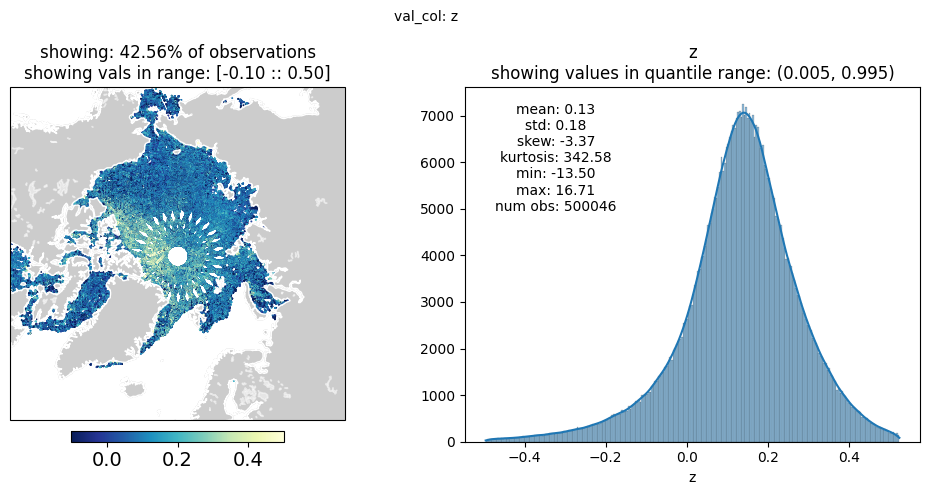

In [6]:

# plot observations and histogram
fig, stats_df = plot_wrapper(plt_df=df,
                             val_col=val_col,
                             max_obs=500_000,
                             vmin_max=[-0.1, 0.5],
                             projection=projection,
                             extent=extent)

plt.show()

# bin raw data
bin by date, source - returns a DataSet

In [7]:

bin_ds = DataPrep.bin_data_by(df=df.loc[(df['z'] > -0.35) & (df['z'] < 0.65)],
                              by_cols=['t', 'source'],
                              val_col=val_col,
                              x_col='x',
                              y_col='y',
                              grid_res=50_000,
                              x_range=[-4500_000.0, 4500_000.0],
                              y_range=[-4500_000.0, 4500_000.0])

# convert bin data to DataFrame
# - removing all the nans that would be added at grid locations away from data
bin_df = bin_ds.to_dataframe().dropna().reset_index()

'bin_data_by': 1.616 seconds


# plot binned data

'stats_on_vals': 0.007 seconds
plotting pcolormesh...
'plot_pcolormesh': 0.021 seconds
plotting hist (using all data)...


'plot_hist': 0.212 seconds
'plot_wrapper': 0.300 seconds


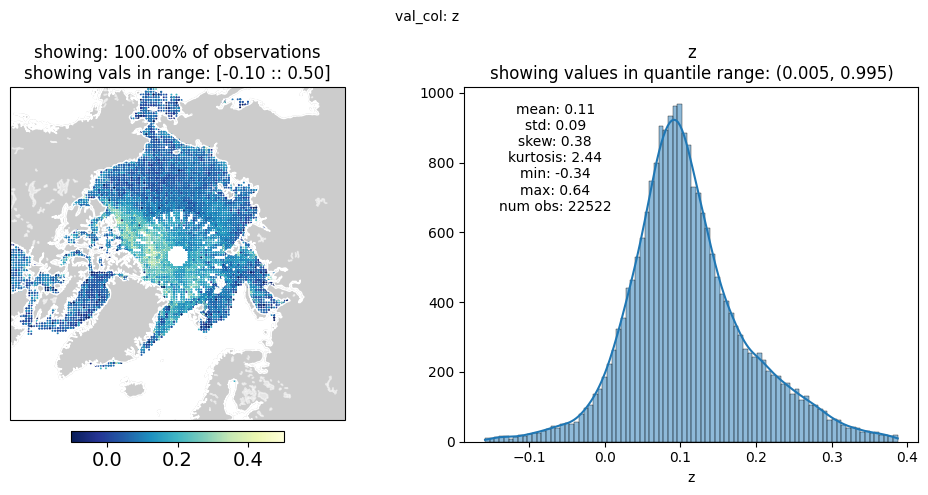

In [8]:

# this will plot all observations, some on top of each other
bin_df['lon'], bin_df['lat'] = EASE2toWGS84(bin_df['x'], bin_df['y'],
                                            lat_0=lat_0, lon_0=lon_0)

# plot observations and histogram
fig, stats_df = plot_wrapper(plt_df=bin_df,
                             val_col=val_col,
                             max_obs=500_000,
                             vmin_max=[-0.1, 0.5],
                             projection=projection,
                             extent=extent)

plt.show()

# expert locations
on evenly spaced grid

In [9]:

xy_grid = grid_2d_flatten(x_range=expert_x_range,
                          y_range=expert_y_range,
                          step_size=expert_spacing)

# store in dataframe
eloc = pd.DataFrame(xy_grid, columns=['x', 'y'])

# add a time coordinate
eloc['t'] = np.floor(df['t'].mean())

# plot expert locations

'plot_pcolormesh': 0.021 seconds


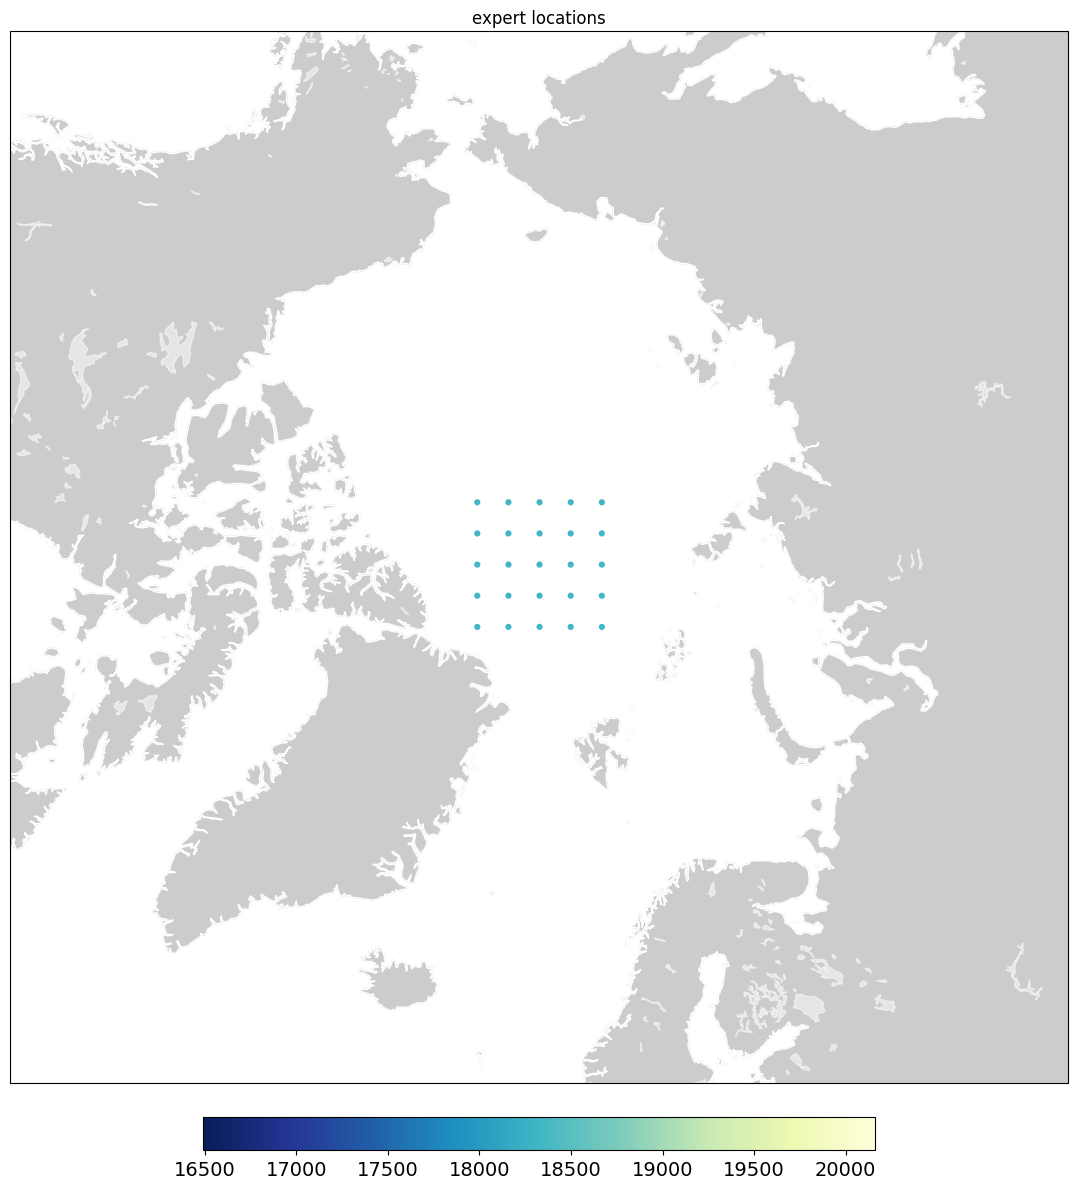

In [10]:

eloc['lon'], eloc['lat'] = EASE2toWGS84(eloc['x'], eloc['y'],
                                        lat_0=lat_0, lon_0=lon_0)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection(projection))

plot_pcolormesh(ax=ax,
                lon=eloc['lon'],
                lat=eloc['lat'],
                plot_data=eloc['t'],
                title="expert locations",
                scatter=True,
                s=20,
                fig=fig,
                extent=extent)

plt.tight_layout()
plt.show()

# prediction locations

In [11]:

pred_xy_grid = grid_2d_flatten(x_range=expert_x_range,
                               y_range=expert_y_range,
                               step_size=pred_spacing)

# store in dataframe
# NOTE: the missing 't' coordinate will be determine by the expert location
# - alternatively the prediction location can be specified
ploc = pd.DataFrame(pred_xy_grid, columns=['x', 'y'])

ploc['lon'], ploc['lat'] = EASE2toWGS84(ploc['x'], ploc['y'],
                                        lat_0=lat_0, lon_0=lon_0)

# identify if a position is in the ocean (water) or not
ploc["is_in_ocean"] = globe.is_ocean(ploc['lat'], ploc['lon'])

# keep only prediction locations in ocean
ploc = ploc.loc[ploc["is_in_ocean"]]

# plot prediction locations

'plot_pcolormesh': 0.014 seconds


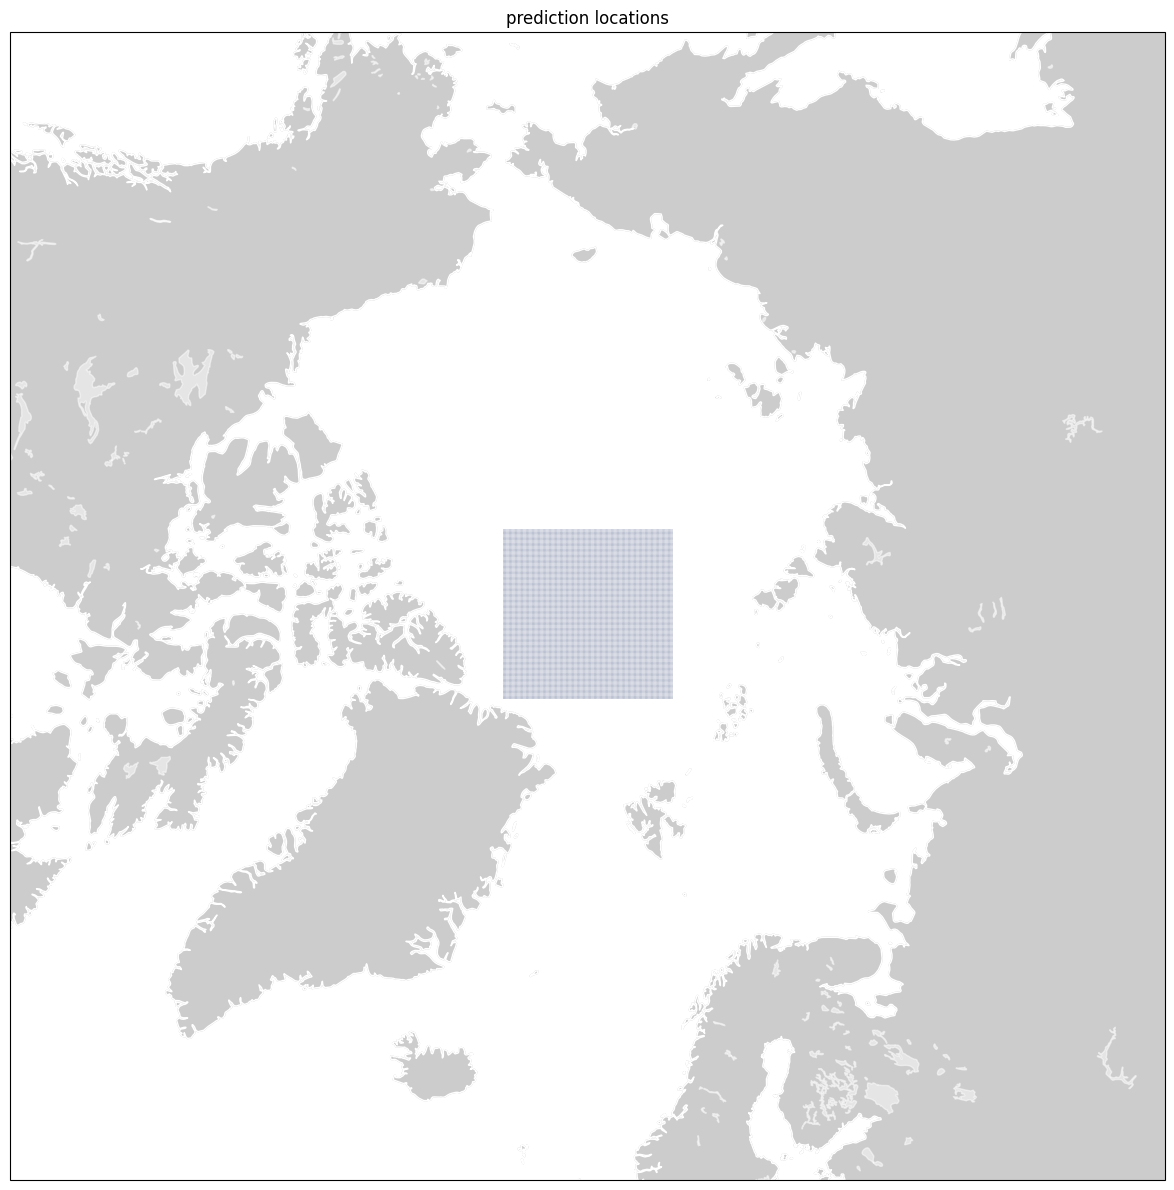

In [12]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection(projection))

plot_pcolormesh(ax=ax,
                lon=ploc['lon'],
                lat=ploc['lat'],
                plot_data=np.full(len(ploc), 1.0),  # np.arange(len(ploc)),
                title="prediction locations",
                scatter=True,
                s=0.1,
                # fig=fig,
                extent=extent)

plt.tight_layout()
plt.show()

# configurations:

In [13]:

# observation data
data = {
    "data_source": bin_df,
    "obs_col": "z",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert
    "local_select": [
        {
            "col": "t",
            "comp": "<=",
            "val": 4
        },
        {
            "col": "t",
            "comp": ">=",
            "val": -4
        },
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<",
            "val": training_radius
        }
    ]
}

# local expert locations
local_expert = {
    "source": eloc
}

# model
model = {
    "oi_model": "GPflowGPRModel",
    "init_params": {
        # scale (divide) coordinates
        "coords_scale": [50000, 50000, 1],
        # can specify initial parameters values for model:
        # "noise_variance": 0.10,
        # "kernel_kwargs": {
        #     "lengthscales": [2.0, 2.0, 1.0],
        #     "variance": 0.05
        # }
    },
    # keyword arguments to be passed into each model/local expert's optimise_parameters method
    "optim_kwargs": {
        # parameters to be fixed (not trainable)
        # "fixed_params": ["likelihood_variance"]
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)
        # - given in unscaled units
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [600000, 600000, 9]
        },
        "likelihood_variance": {
            "low": 0.00125,
            "high": 0.01
        }
    }
}

# prediction locations
pred_loc = {
    "method": "from_dataframe",
    "df": ploc,
    "max_dist": inference_radius
}

# Local Expert OI

if process falls over here when calling run(), try: Runtime -> "Restart and run all"

In [14]:

locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

# run optimal interpolation
# - no predictions locations supplied
store_path = get_parent_path("results", "inline_example.h5")

# for the purposes of a simple example, if store_path exists: delete it
if os.path.exists(store_path):
    cprint(f"removing: {store_path}", "FAIL")
    os.remove(store_path)

# run optimal interpolation
locexp.run(store_path=store_path,
           optimise=True,
           check_config_compatible=False)

'data_select': 0.001 seconds
'load': 0.001 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str


in json_serializable - key: 'df' has value DataFrame/Series, but is too long: 40000 >  100
storing as str
---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details in the file'
will now close object

--------------------------------------------------
1 / 25
current local expert:
          x         y        t   lon        lat
0 -400000.0 -400000.0  18326.0 -45.0  84.933616
'data_select': 0.001 seconds
'load': 0.001 seconds
'local_data_select': 0.007 seconds
number obs: 402
setting lengthscales to: [1. 1. 1.]
'__init__': 0.066 seconds
'get_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.026 seconds


'optimise_parameters': 2.190 seconds
'get_parameters': 0.005 seconds
parameters:
lengthscales: array([5.18518225, 3.2196388 , 8.99998909]) 
kernel_variance: 0.015251960320437637
likelihood_variance: 0.0033263315432974965
'predict': 0.160 seconds


total run time : 2.83 seconds
--------------------------------------------------
2 / 25
current local expert:
          x         y        t        lon      lat
1 -200000.0 -400000.0  18326.0 -26.565051  85.9952
'local_data_select': 0.006 seconds
number obs: 538
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.638 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([3.77494305, 2.17842108, 8.99999918]) 
kernel_variance: 0.013368082738827579
likelihood_variance: 0.0020117314690438594


'predict': 0.259 seconds
total run time : 2.29 seconds
--------------------------------------------------
3 / 25
current local expert:
     x         y        t  lon        lat
2  0.0 -400000.0  18326.0  0.0  86.418156
'local_data_select': 0.006 seconds
number obs: 519
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.180 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([4.39984156, 7.18095879, 8.99999795]) 
kernel_variance: 0.009120415704262684
likelihood_variance: 0.0018969897287739795


'predict': 0.260 seconds
total run time : 1.83 seconds
--------------------------------------------------
4 / 25
current local expert:
          x         y        t        lon      lat
3  200000.0 -400000.0  18326.0  26.565051  85.9952
'local_data_select': 0.007 seconds
number obs: 525
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.125 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([6.84400339, 6.23964815, 8.99979748]) 
kernel_variance: 0.014944354861840812
likelihood_variance: 0.0016662922082378666


'predict': 0.264 seconds
total run time : 1.78 seconds
--------------------------------------------------
5 / 25
current local expert:
          x         y        t   lon        lat
4  400000.0 -400000.0  18326.0  45.0  84.933616
'local_data_select': 0.006 seconds
number obs: 409
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 0.740 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([6.70994971, 4.73287436, 8.99998787]) 
kernel_variance: 0.013182714519771526
likelihood_variance: 0.0016309342610527026
'predict': 0.161 seconds


total run time : 1.28 seconds
--------------------------------------------------
6 / 25
current local expert:
          x         y        t        lon      lat
5 -400000.0 -200000.0  18326.0 -63.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 566
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


**********
optimization failed!
'optimise_parameters': 1.756 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([6.87515825, 9.42140799, 3.38400392]) 
kernel_variance: 0.0234054708427411
likelihood_variance: 0.0024454369299351034


'predict': 0.279 seconds
total run time : 2.43 seconds
--------------------------------------------------
7 / 25
current local expert:
          x         y        t   lon        lat
6 -200000.0 -200000.0  18326.0 -45.0  87.467477
'local_data_select': 0.006 seconds
number obs: 548
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


**********
optimization failed!
'optimise_parameters': 2.285 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 6.4622363 , 12.        ,  8.99998989]) 
kernel_variance: 0.02839820263618021
likelihood_variance: 0.0018270041796673681


'predict': 0.318 seconds
total run time : 3.00 seconds
--------------------------------------------------
8 / 25
current local expert:
     x         y        t  lon        lat
7  0.0 -200000.0  18326.0  0.0  88.209314
'local_data_select': 0.006 seconds
number obs: 501
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.023 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([6.0867854 , 5.81865096, 8.99999681]) 
kernel_variance: 0.009910320491453206
likelihood_variance: 0.001521808251644771


'predict': 0.282 seconds
total run time : 1.71 seconds
--------------------------------------------------
9 / 25
current local expert:
          x         y        t   lon        lat
8  200000.0 -200000.0  18326.0  45.0  87.467477
'local_data_select': 0.007 seconds
number obs: 525
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds


'optimise_parameters': 1.681 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([8.09295626, 4.33062803, 8.18147899]) 
kernel_variance: 0.013011396496893987
likelihood_variance: 0.0012717573269581414


'predict': 0.304 seconds
total run time : 2.39 seconds
--------------------------------------------------
10 / 25
current local expert:
          x         y        t        lon      lat
9  400000.0 -200000.0  18326.0  63.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 569
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.694 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.92871006,  6.49540471,  8.72275757]) 
kernel_variance: 0.013975739820522559
likelihood_variance: 0.0016707081752818994


'predict': 0.273 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 2.49 seconds
--------------------------------------------------
11 / 25
current local expert:
           x    y        t   lon        lat
10 -400000.0  0.0  18326.0 -90.0  86.418156
'local_data_select': 0.006 seconds
number obs: 591
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds


'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.026 seconds


'optimise_parameters': 2.016 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 7.24301087, 11.99987378,  3.80924605]) 
kernel_variance: 0.01956517319240185
likelihood_variance: 0.0023657032568156276


'predict': 0.302 seconds
total run time : 2.71 seconds
--------------------------------------------------
12 / 25
current local expert:
           x    y        t   lon        lat
11 -200000.0  0.0  18326.0 -90.0  88.209314
'local_data_select': 0.007 seconds
number obs: 516
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.088 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.99996337,  7.41811631,  4.68766989]) 
kernel_variance: 0.028613447922813402
likelihood_variance: 0.0018067208179401064


'predict': 0.282 seconds
total run time : 1.76 seconds
--------------------------------------------------
13 / 25
current local expert:
      x    y        t  lon   lat
12  0.0  0.0  18326.0  0.0  90.0
'local_data_select': 0.006 seconds
number obs: 522
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.306 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.86076982, 11.83061267,  8.99999634]) 
kernel_variance: 0.010490567513137816
likelihood_variance: 0.0012500000616336865


'predict': 0.299 seconds
total run time : 2.00 seconds
--------------------------------------------------
14 / 25
current local expert:
           x    y        t   lon        lat
13  200000.0  0.0  18326.0  90.0  88.209314
'local_data_select': 0.006 seconds
number obs: 501
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.320 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([10.88011436,  5.80125654,  8.99986118]) 
kernel_variance: 0.014733935666720745
likelihood_variance: 0.0012912769336350393


'predict': 0.284 seconds
total run time : 2.00 seconds
--------------------------------------------------
15 / 25
current local expert:
           x    y        t   lon        lat
14  400000.0  0.0  18326.0  90.0  86.418156
'local_data_select': 0.006 seconds
number obs: 564
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.447 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([9.75898604, 6.26795872, 8.9999778 ]) 
kernel_variance: 0.008280192922011884
likelihood_variance: 0.001351048066102522


'predict': 0.278 seconds
total run time : 2.12 seconds
--------------------------------------------------
16 / 25
current local expert:
           x         y        t         lon      lat
15 -400000.0  200000.0  18326.0 -116.565051  85.9952
'local_data_select': 0.006 seconds
number obs: 556
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.466 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 7.10967565, 11.99997547,  3.40255658]) 
kernel_variance: 0.020403337921804814
likelihood_variance: 0.001968814297516638


'predict': 0.270 seconds
total run time : 2.13 seconds
--------------------------------------------------
17 / 25
current local expert:
           x         y        t    lon        lat
16 -200000.0  200000.0  18326.0 -135.0  87.467477
'local_data_select': 0.007 seconds
number obs: 556
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.786 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.99990841, 11.99998534,  3.79117828]) 
kernel_variance: 0.021742751280636807
likelihood_variance: 0.0017348602904437432


'predict': 0.320 seconds
total run time : 2.50 seconds
--------------------------------------------------
18 / 25
current local expert:
      x         y        t    lon        lat
17  0.0  200000.0  18326.0  180.0  88.209314
'local_data_select': 0.006 seconds
number obs: 513
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.024 seconds


'optimise_parameters': 1.068 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([7.81936368, 7.58679188, 8.99999998]) 
kernel_variance: 0.008812716397349098
likelihood_variance: 0.0012500001531666658


'predict': 0.294 seconds
total run time : 1.76 seconds
--------------------------------------------------
19 / 25
current local expert:
           x         y        t    lon        lat
18  200000.0  200000.0  18326.0  135.0  87.467477
'local_data_select': 0.006 seconds
number obs: 532
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.024 seconds


'optimise_parameters': 1.116 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 7.46144366, 11.99998244,  8.99999987]) 
kernel_variance: 0.007188224237062229
likelihood_variance: 0.001410707517344195


'predict': 0.309 seconds
total run time : 1.83 seconds
--------------------------------------------------
20 / 25
current local expert:
           x         y        t         lon      lat
19  400000.0  200000.0  18326.0  116.565051  85.9952
'local_data_select': 0.007 seconds
number obs: 540
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.238 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.99994992,  7.62608557,  7.89773345]) 
kernel_variance: 0.010424757568026197
likelihood_variance: 0.001446916573548475


'predict': 0.281 seconds
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
total run time : 2.07 seconds
--------------------------------------------------
21 / 25
current local expert:
           x         y        t    lon        lat
20 -400000.0  400000.0  18326.0 -135.0  84.933616
'local_data_select': 0.006 seconds
number obs: 450
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds


'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.215 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.99994606, 11.99990943,  2.99921322]) 
kernel_variance: 0.01877397338395873
likelihood_variance: 0.001740871935109944


'predict': 0.183 seconds
total run time : 1.80 seconds
--------------------------------------------------
22 / 25
current local expert:
           x         y        t         lon      lat
21 -200000.0  400000.0  18326.0 -153.434949  85.9952
'local_data_select': 0.007 seconds
number obs: 543
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds


'optimise_parameters': 1.203 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([4.97102647, 8.53978974, 8.99999702]) 
kernel_variance: 0.010471833750417216
likelihood_variance: 0.0014508711917120315


'predict': 0.262 seconds
total run time : 1.88 seconds
--------------------------------------------------
23 / 25
current local expert:
      x         y        t    lon        lat
22  0.0  400000.0  18326.0  180.0  86.418156
'local_data_select': 0.006 seconds
number obs: 552
setting lengthscales to: [1. 1. 1.]
'__init__': 0.029 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.025 seconds


'optimise_parameters': 1.404 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 5.59684729, 11.99998229,  8.99999973]) 
kernel_variance: 0.008968477715724356
likelihood_variance: 0.0016418048697338695


'predict': 0.279 seconds
total run time : 2.11 seconds
--------------------------------------------------
24 / 25
current local expert:
           x         y        t         lon      lat
23  200000.0  400000.0  18326.0  153.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 536
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds


'optimise_parameters': 1.146 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.99971927, 11.99999931,  8.99999999]) 
kernel_variance: 0.005546008937381494
likelihood_variance: 0.001462221192412413


'predict': 0.274 seconds
total run time : 1.83 seconds
--------------------------------------------------
25 / 25
current local expert:
           x         y        t    lon        lat
24  400000.0  400000.0  18326.0  135.0  84.933616
'local_data_select': 0.006 seconds
number obs: 431
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds


'optimise_parameters': 0.952 seconds
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([11.99999529,  7.22856027,  8.10441799]) 
kernel_variance: 0.005731038654881918
likelihood_variance: 0.0012500000856986253
'predict': 0.163 seconds


total run time : 1.52 seconds
storing any remaining tables
SAVING RESULTS TO TABLES:
run_details
preds
lengthscales
kernel_variance
likelihood_variance
'run': 52.294 seconds


results are store in hdf5

In [15]:

# extract, store in dict
dfs, oi_config = get_results_from_h5file(store_path)

print(f"tables in results file: {list(dfs.keys())}")

reading in results
getting all tables


merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
tables in results file: ['expert_locs', 'kernel_variance', 'lengthscales', 'likelihood_variance', 'oi_config', 'preds', 'run_details']


Plot Hyper Parameters

'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.018 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds


'plot_pcolormesh': 0.017 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.016 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.016 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.015 seconds


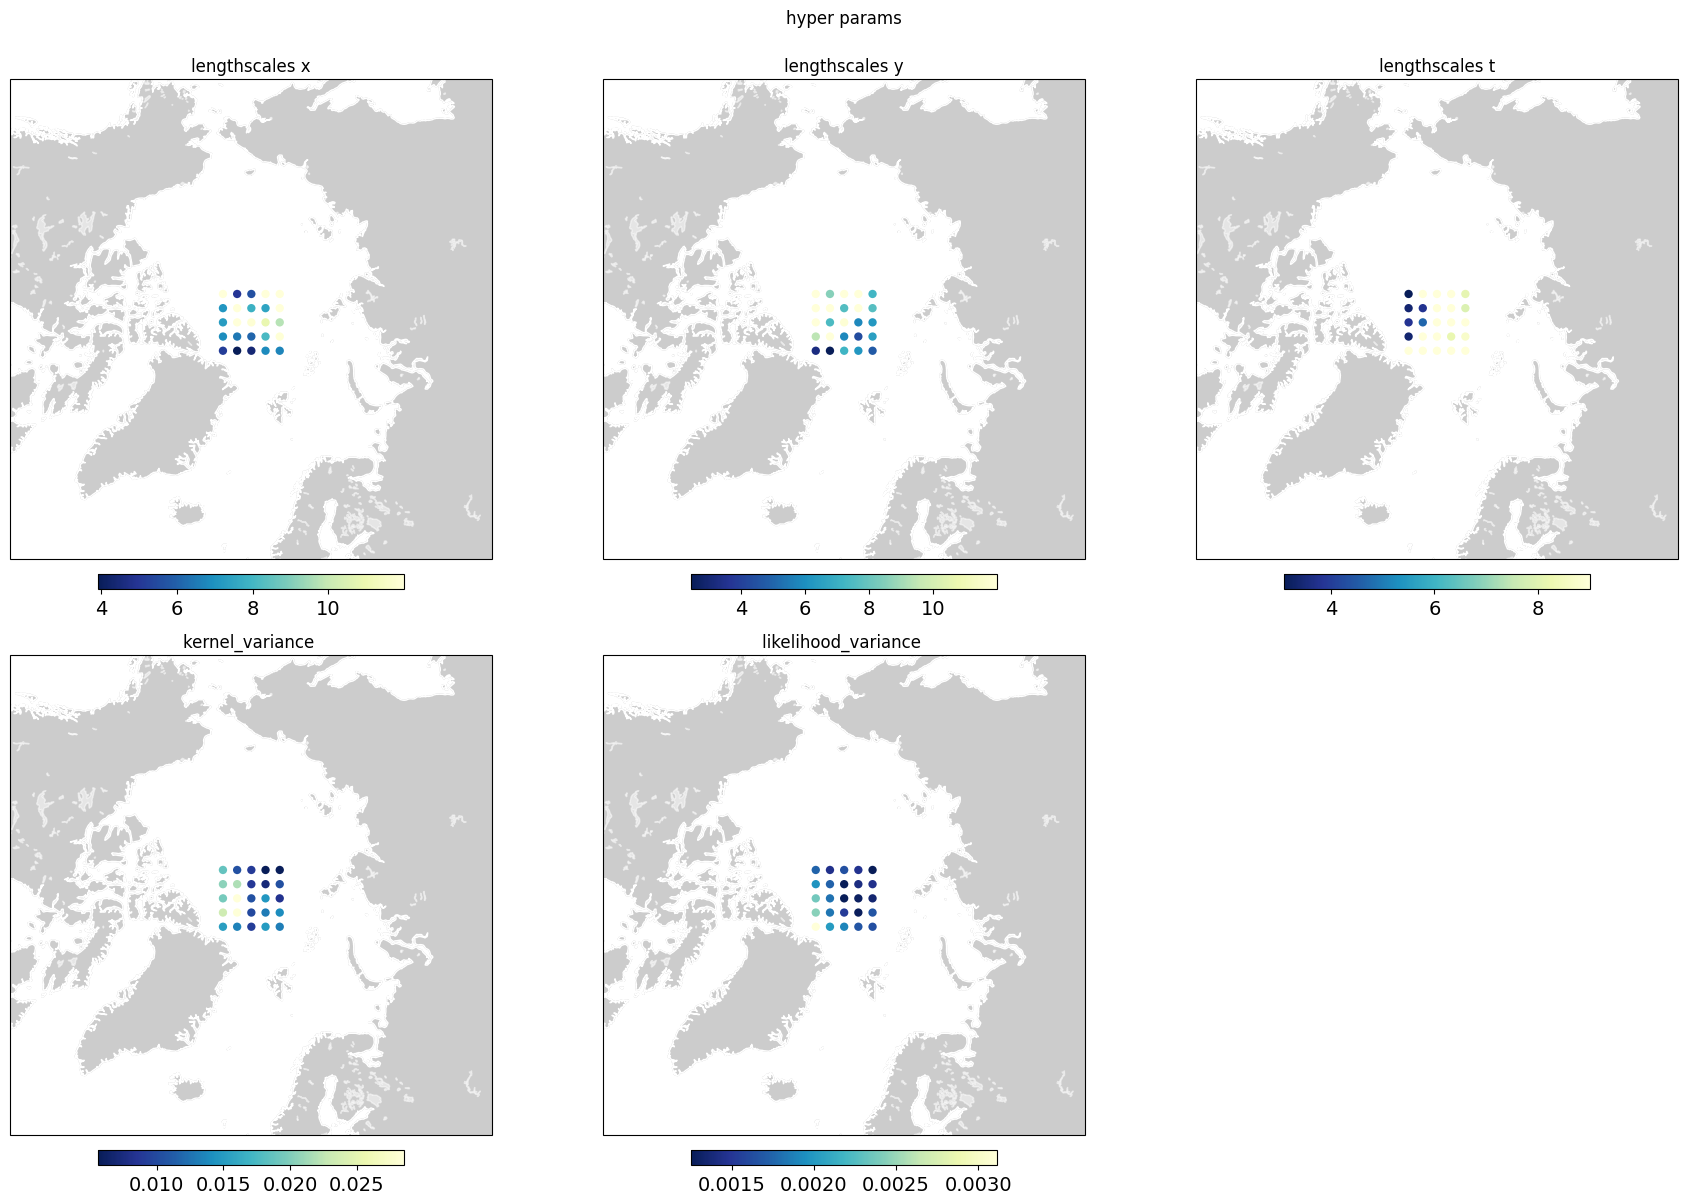

In [16]:

# a template to be used for each created plot config
plot_template = {
    "plot_type": "heatmap",
    "x_col": "x",
    "y_col": "y",
    # use a northern hemisphere projection, centered at (lat,lon) = (90,0)
    "subplot_kwargs": {"projection": projection},
    "lat_0": lat_0,
    "lon_0": lon_0,
    # any additional arguments for plot_hist
    "plot_kwargs": {
        "scatter": True,
    },
    # lat/lon_col needed if scatter = True
    # TODO: remove the need for this
    "lat_col": "lat",
    "lon_col": "lon",
}

fig = plot_hyper_parameters(dfs,
                            coords_col=oi_config[0]['data']['coords_col'],  # ['x', 'y', 't']
                            row_select=None,  # this could be used to select a specific date in results data
                            table_names=["lengthscales", "kernel_variance", "likelihood_variance"],
                            plot_template=plot_template,
                            plots_per_row=3,
                            suptitle="hyper params",
                            qvmin=0.01,
                            qvmax=0.99)

plt.show()

Smooth Hyper Parameters

In [17]:

smooth_config = {
    # get hyper parameters from the previously stored results
    "result_file": store_path,
    # store the smoothed hyper parameters in the same file
    "output_file": store_path,
    # get the hyper params from tables ending with this suffix ("" is default):
    "reference_table_suffix": "",
    # newly smoothed hyper parameters will be store in tables ending with table_suffix
    "table_suffix": "_SMOOTHED",
    # dimension names to smooth over
    "xy_dims": [
        "x",
        "y"
    ],
    # parameters to smooth
    "params_to_smooth": [
        "lengthscales",
        "kernel_variance",
        "likelihood_variance"
    ],
    # length scales for the kernel smoother in each dimension
    # - as well as any min/max values to apply
    "smooth_config_dict": {
        "lengthscales": {
            "l_x": 200_000,
            "l_y": 200_000
        },
        "likelihood_variance": {
            "l_x": 200_000,
            "l_y": 200_000,
            "max": 0.3
        },
        "kernel_variance": {
            "l_x": 200_000,
            "l_y": 200_000,
            "max": 0.1
        }
    },
    "save_config_file": True
}

smooth_result_config_file = smooth_hyperparameters(**smooth_config)

# modify the model configuration to include "load_params"
model_load_params = model.copy()
model_load_params["load_params"] = {
    "file": store_path,
    "table_suffix": smooth_config["table_suffix"]
}

locexp_smooth = LocalExpertOI(expert_loc_config=local_expert,
                              data_config=data,
                              model_config=model_load_params,
                              pred_loc_config=pred_loc)

# run optimal interpolation (again)
# - this time don't optimise hyper parameters, but make predictions
# - store results in new tables ending with '_SMOOTHED'
locexp_smooth.run(store_path=store_path,
                  optimise=False,
                  predict=True,
                  table_suffix=smooth_config['table_suffix'],
                  check_config_compatible=False)

found model_name: GPflowGPRModel
setting lengthscales to: [1.]
'__init__': 0.026 seconds
reading in results
selecting only tables: ['lengthscales', 'kernel_variance', 'likelihood_variance']
'data_select': 0.000 seconds
'load': 0.001 seconds
expert_locations data will not be merged on results data
adding smoothed table: lengthscales_SMOOTHED
adding smoothed table: kernel_variance_SMOOTHED
adding smoothed table: likelihood_variance_SMOOTHED
writing (smoothed) hyper parameters to:
/home/runner/work/GPSat/GPSat/results/inline_example.h5
table_suffix:_SMOOTHED
writing: lengthscales_SMOOTHED to table
writing: kernel_variance_SMOOTHED to table
writing: likelihood_variance_SMOOTHED to table
writing config (to use to make predictions with smoothed values) to:
/home/runner/work/GPSat/GPSat/results/inline_example_SMOOTHED.json
'data_select': 0.000 seconds
'load': 0.000 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 22522 >  100
storing as str
in jso

---------
storing expert locations in 'expert_locs' table
exception occurred: 'No object named expert_locs_SMOOTHED in the file'
will now close object

---------
dropping expert locations that already exists in 'run_details' table
exception occurred: 'No object named run_details_SMOOTHED in the file'
will now close object

--------------------------------------------------
1 / 25
current local expert:
          x         y        t   lon        lat
0 -400000.0 -400000.0  18326.0 -45.0  84.933616
'data_select': 0.000 seconds
'load': 0.001 seconds
'local_data_select': 0.006 seconds
number obs: 402
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'get_parameters': 0.005 seconds
'_read_params_from_file': 0.076 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters


'get_parameters': 0.004 seconds
parameters:
lengthscales: array([5.73489626, 6.15229577, 7.51415594]) 
kernel_variance: 0.01819056731260972
likelihood_variance: 0.005625
'predict': 0.145 seconds


total run time : 0.65 seconds
--------------------------------------------------
2 / 25
current local expert:
          x         y        t        lon      lat
1 -200000.0 -400000.0  18326.0 -26.565051  85.9952
'local_data_select': 0.006 seconds
number obs: 538
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.064 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.006 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([5.72415705, 6.29357112, 8.21639143]) 
kernel_variance: 0.016447924388383984
likelihood_variance: 0.005625


'predict': 0.254 seconds


total run time : 0.75 seconds
--------------------------------------------------
3 / 25
current local expert:
     x         y        t  lon        lat
2  0.0 -400000.0  18326.0  0.0  86.418156
'local_data_select': 0.006 seconds
number obs: 519
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.072 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.008 seconds
'set_likelihood_variance_constraints': 0.026 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([6.22035795, 6.31765587, 8.70617345]) 
kernel_variance: 0.013844313646142088
likelihood_variance: 0.005625


'predict': 0.250 seconds


total run time : 0.75 seconds
--------------------------------------------------
4 / 25
current local expert:
          x         y        t        lon      lat
3  200000.0 -400000.0  18326.0  26.565051  85.9952
'local_data_select': 0.006 seconds
number obs: 525
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([7.24807047, 5.96815503, 8.82125339]) 
kernel_variance: 0.013042630316857111
likelihood_variance: 0.005625


'predict': 0.246 seconds


total run time : 0.74 seconds
--------------------------------------------------
5 / 25
current local expert:
          x         y        t   lon        lat
4  400000.0 -400000.0  18326.0  45.0  84.933616
'local_data_select': 0.006 seconds
number obs: 409
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([8.10323576, 5.64215751, 8.8404427 ]) 
kernel_variance: 0.013225876777264426
likelihood_variance: 0.005625


'predict': 0.155 seconds


total run time : 0.64 seconds
--------------------------------------------------
6 / 25
current local expert:
          x         y        t        lon      lat
5 -400000.0 -200000.0  18326.0 -63.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 566
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'_read_params_from_file': 0.067 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([6.95927932, 8.44094144, 6.19315119]) 
kernel_variance: 0.02066941549140503
likelihood_variance: 0.005625


'predict': 0.271 seconds


total run time : 0.75 seconds
--------------------------------------------------
7 / 25
current local expert:
          x         y        t   lon        lat
6 -200000.0 -200000.0  18326.0 -45.0  87.467477
'local_data_select': 0.006 seconds
number obs: 548
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.064 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([7.26337444, 8.10386541, 7.33815906]) 
kernel_variance: 0.018750428054645444
likelihood_variance: 0.005625


'predict': 0.298 seconds


total run time : 0.77 seconds
--------------------------------------------------
8 / 25
current local expert:
     x         y        t  lon        lat
7  0.0 -200000.0  18326.0  0.0  88.209314
'local_data_select': 0.006 seconds
number obs: 501
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.064 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([7.71900497, 7.36778701, 8.34009253]) 
kernel_variance: 0.014903233354508176
likelihood_variance: 0.005625


'predict': 0.261 seconds


total run time : 0.74 seconds
--------------------------------------------------
9 / 25
current local expert:
          x         y        t   lon        lat
8  200000.0 -200000.0  18326.0  45.0  87.467477
'local_data_select': 0.006 seconds
number obs: 525
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([8.49037633, 6.49337642, 8.70554387]) 
kernel_variance: 0.012852545681274929
likelihood_variance: 0.005625


'predict': 0.295 seconds


total run time : 0.81 seconds
--------------------------------------------------
10 / 25
current local expert:
          x         y        t        lon      lat
9  400000.0 -200000.0  18326.0  63.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 569
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.066 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([9.26028992, 6.07482088, 8.76478383]) 
kernel_variance: 0.012492198893360734
likelihood_variance: 0.005625


'predict': 0.280 seconds


SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.84 seconds
--------------------------------------------------
11 / 25
current local expert:
           x    y        t   lon        lat
10 -400000.0  0.0  18326.0 -90.0  86.418156
'local_data_select': 0.006 seconds
number obs: 591
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds


'set_likelihood_variance_constraints': 0.025 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 8.27414434, 10.22349163,  5.01773265]) 
kernel_variance: 0.021155333654392875
likelihood_variance: 0.005625


'predict': 0.303 seconds


total run time : 0.81 seconds
--------------------------------------------------
12 / 25
current local expert:
           x    y        t   lon        lat
11 -200000.0  0.0  18326.0 -90.0  88.209314
'local_data_select': 0.006 seconds
number obs: 516
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.074 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([8.8479561 , 9.58258813, 6.38658148]) 
kernel_variance: 0.01912433225042327
likelihood_variance: 0.005625


'predict': 0.281 seconds


total run time : 0.79 seconds
--------------------------------------------------
13 / 25
current local expert:
      x    y        t  lon   lat
12  0.0  0.0  18326.0  0.0  90.0
'local_data_select': 0.007 seconds
number obs: 522
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.071 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.025 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([9.13852657, 8.70114399, 7.91463961]) 
kernel_variance: 0.014660416097052332
likelihood_variance: 0.005625


'predict': 0.289 seconds


total run time : 0.79 seconds
--------------------------------------------------
14 / 25
current local expert:
           x    y        t   lon        lat
13  200000.0  0.0  18326.0  90.0  88.209314
'local_data_select': 0.006 seconds
number obs: 501
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.064 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([9.51351949, 7.73086485, 8.61929628]) 
kernel_variance: 0.011779769809063076
likelihood_variance: 0.005625


'predict': 0.270 seconds


total run time : 0.76 seconds
--------------------------------------------------
15 / 25
current local expert:
           x    y        t   lon        lat
14  400000.0  0.0  18326.0  90.0  86.418156
'local_data_select': 0.006 seconds
number obs: 564
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.070 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.025 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([10.07618425,  7.07216258,  8.69080709]) 
kernel_variance: 0.010950245238431262
likelihood_variance: 0.005625


'predict': 0.268 seconds


total run time : 0.77 seconds
--------------------------------------------------
16 / 25
current local expert:
           x         y        t         lon      lat
15 -400000.0  200000.0  18326.0 -116.565051  85.9952
'local_data_select': 0.006 seconds
number obs: 556
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 8.87492366, 10.9700379 ,  4.67482246]) 
kernel_variance: 0.019389138262360436
likelihood_variance: 0.005625


'predict': 0.259 seconds


total run time : 0.75 seconds
--------------------------------------------------
17 / 25
current local expert:
           x         y        t    lon        lat
16 -200000.0  200000.0  18326.0 -135.0  87.467477
'local_data_select': 0.006 seconds
number obs: 556
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.065 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 9.02414022, 10.3253465 ,  6.1563721 ]) 
kernel_variance: 0.016965998325579212
likelihood_variance: 0.005625


'predict': 0.307 seconds


total run time : 0.80 seconds
--------------------------------------------------
18 / 25
current local expert:
      x         y        t    lon        lat
17  0.0  200000.0  18326.0  180.0  88.209314
'local_data_select': 0.006 seconds
number obs: 513
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.066 seconds
'set_parameters': 0.007 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([9.09928062, 9.78071908, 7.83628826]) 
kernel_variance: 0.012666607361097171
likelihood_variance: 0.005625


'predict': 0.281 seconds


total run time : 0.78 seconds
--------------------------------------------------
19 / 25
current local expert:
           x         y        t    lon        lat
18  200000.0  200000.0  18326.0  135.0  87.467477
'local_data_select': 0.006 seconds
number obs: 532
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([9.67664142, 9.15511903, 8.58029635]) 
kernel_variance: 0.009829028714011824
likelihood_variance: 0.005625


'predict': 0.293 seconds


total run time : 0.79 seconds
--------------------------------------------------
20 / 25
current local expert:
           x         y        t         lon      lat
19  400000.0  200000.0  18326.0  116.565051  85.9952
'local_data_select': 0.006 seconds
number obs: 540
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.075 seconds
'set_parameters': 0.010 seconds
'set_lengthscales_constraints': 0.009 seconds
'set_likelihood_variance_constraints': 0.027 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([10.49402394,  8.30011417,  8.55484771]) 
kernel_variance: 0.009064716874602533
likelihood_variance: 0.005625


'predict': 0.258 seconds


SAVING RESULTS TO TABLES:
run_details
preds
total run time : 0.88 seconds
--------------------------------------------------
21 / 25
current local expert:
           x         y        t    lon        lat
20 -400000.0  400000.0  18326.0 -135.0  84.933616
'local_data_select': 0.006 seconds
number obs: 450
setting lengthscales to: [1. 1. 1.]
'__init__': 0.025 seconds
'_read_params_from_file': 0.068 seconds


'set_parameters': 0.009 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 8.99882634, 11.05777882,  4.95604446]) 
kernel_variance: 0.017318299281238743
likelihood_variance: 0.005625


'predict': 0.175 seconds


total run time : 0.68 seconds
--------------------------------------------------
22 / 25
current local expert:
           x         y        t         lon      lat
21 -200000.0  400000.0  18326.0 -153.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 543
setting lengthscales to: [1. 1. 1.]
'__init__': 0.026 seconds
'_read_params_from_file': 0.069 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.023 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 8.32678541, 10.54964449,  6.60104747]) 
kernel_variance: 0.014479738850902037
likelihood_variance: 0.005625


'predict': 0.256 seconds


total run time : 0.76 seconds
--------------------------------------------------
23 / 25
current local expert:
      x         y        t    lon        lat
22  0.0  400000.0  18326.0  180.0  86.418156
'local_data_select': 0.006 seconds
number obs: 552
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 8.40500585, 10.40837273,  8.11294036]) 
kernel_variance: 0.010669340399804356
likelihood_variance: 0.005625


'predict': 0.257 seconds


total run time : 0.76 seconds
--------------------------------------------------
24 / 25
current local expert:
           x         y        t         lon      lat
23  200000.0  400000.0  18326.0  153.434949  85.9952
'local_data_select': 0.006 seconds
number obs: 536
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.004 seconds
parameters:
lengthscales: array([ 9.67690642, 10.02479553,  8.61829181]) 
kernel_variance: 0.008193546633878432
likelihood_variance: 0.005625


'predict': 0.255 seconds


total run time : 0.78 seconds
--------------------------------------------------
25 / 25
current local expert:
           x         y        t    lon        lat
24  400000.0  400000.0  18326.0  135.0  84.933616
'local_data_select': 0.006 seconds
number obs: 431
setting lengthscales to: [1. 1. 1.]
'__init__': 0.024 seconds
'_read_params_from_file': 0.068 seconds
'set_parameters': 0.008 seconds
'set_lengthscales_constraints': 0.007 seconds
'set_likelihood_variance_constraints': 0.024 seconds
*** not optimising parameters
'get_parameters': 0.005 seconds
parameters:
lengthscales: array([10.895104  ,  8.99241218,  8.47375162]) 
kernel_variance: 0.007517021521209238
likelihood_variance: 0.005625


'predict': 0.161 seconds


total run time : 0.67 seconds
storing any remaining tables
SAVING RESULTS TO TABLES:
run_details
preds
'run': 19.191 seconds


# Plot Smoothed Hyper Parameters

reading in results
getting all tables


merging on expert location data
table: 'oi_config' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
table: 'oi_config_SMOOTHED' does not have all coords_col: ['x', 'y', 't'] in columns, not merging on expert_locations
'data_select': 0.000 seconds
'load': 0.001 seconds
'data_select': 0.000 seconds
'load': 0.000 seconds
'data_select': 0.000 seconds
'load': 0.000 seconds
'data_select': 0.000 seconds
'load': 0.000 seconds
'data_select': 0.000 seconds
'load': 0.000 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.017 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.016 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.016 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.016 seconds
'data_select': 0.000 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.017 seconds


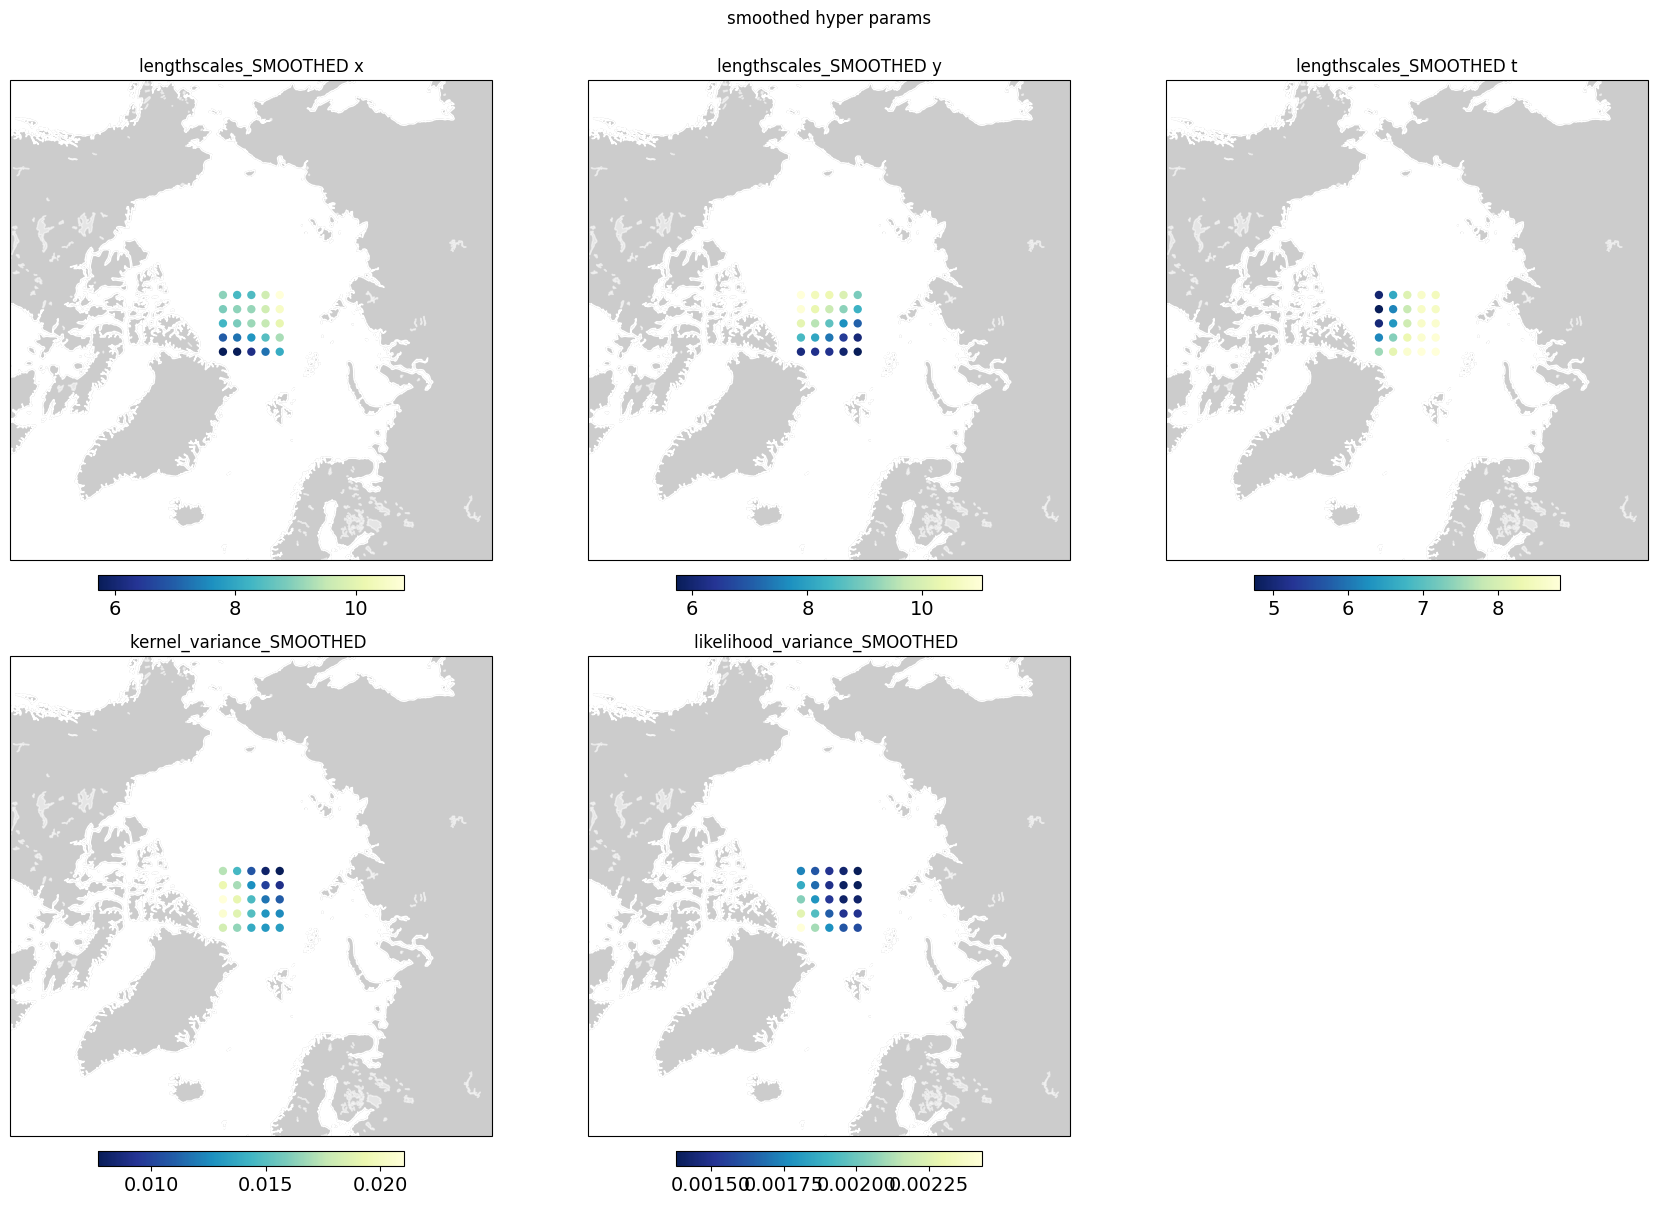

In [18]:
# extract, store in dict
dfs, oi_config = get_results_from_h5file(store_path)

fig = plot_hyper_parameters(dfs,
                            coords_col=oi_config[0]['data']['coords_col'],  # ['x', 'y', 't']
                            row_select=None,
                            table_names=["lengthscales", "kernel_variance", "likelihood_variance"],
                            table_suffix=smooth_config["table_suffix"],
                            plot_template=plot_template,
                            plots_per_row=3,
                            suptitle="smoothed hyper params",
                            qvmin=0.01,
                            qvmax=0.99)

plt.tight_layout()
plt.show()

# get weighted combinations predictions and plot

'data_select': 0.001 seconds
'load': 0.001 seconds
'plot_pcolormesh': 0.035 seconds


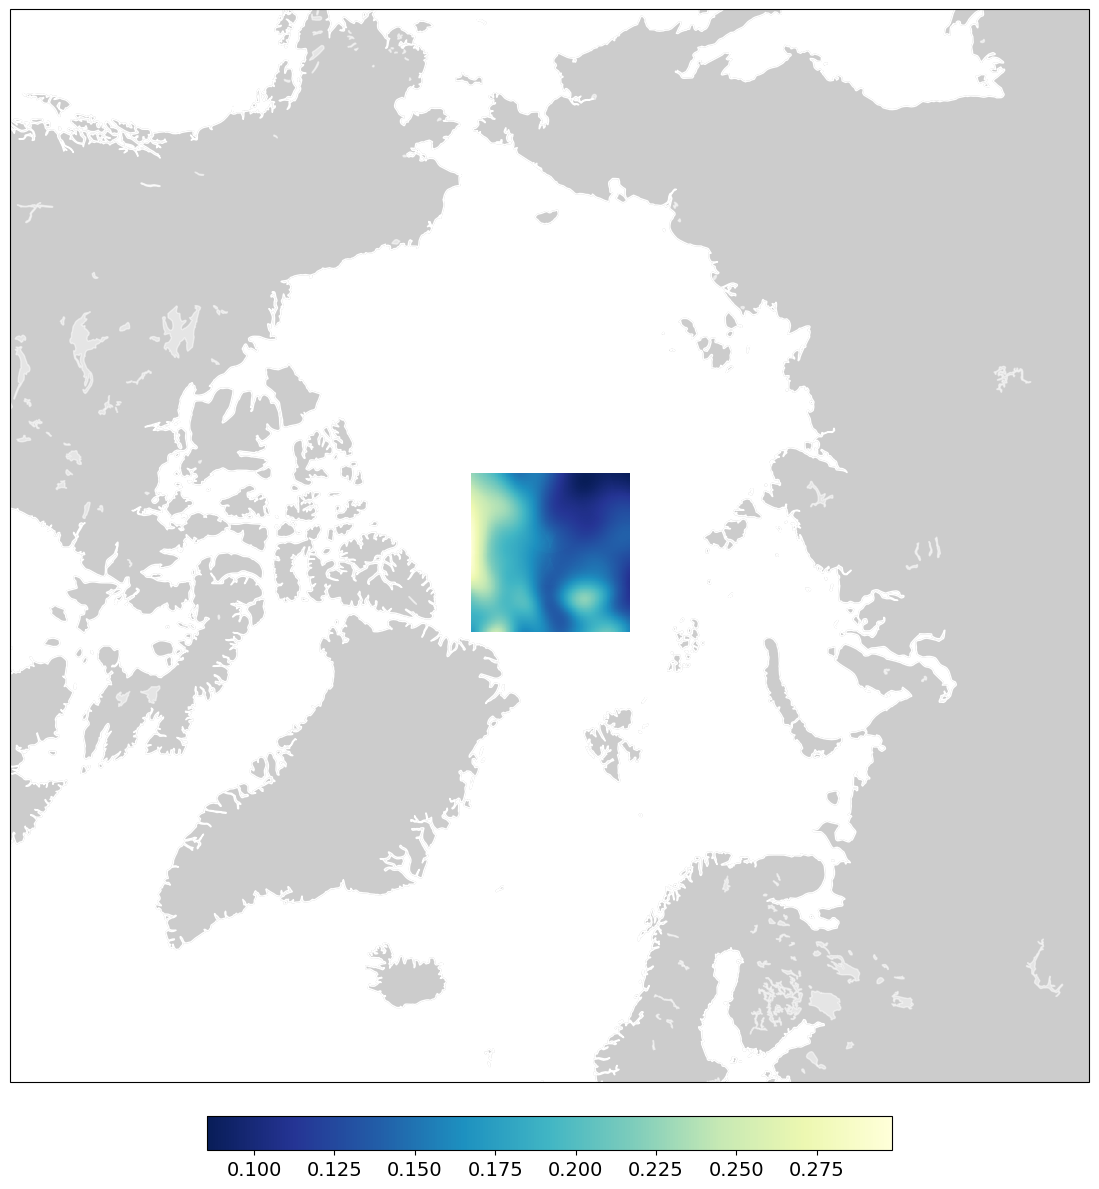

In [19]:

plt_data = dfs["preds" + smooth_config["table_suffix"]]

weighted_values_kwargs = {
    "ref_col": ["pred_loc_x", "pred_loc_y", "pred_loc_t"],
    "dist_to_col": ["x", "y", "t"],
    "val_cols": ["f*", "f*_var"],
    "weight_function": "gaussian",
    "lengthscale": inference_radius/2
}
plt_data = get_weighted_values(df=plt_data, **weighted_values_kwargs)

plt_data['lon'], plt_data['lat'] = EASE2toWGS84(plt_data['pred_loc_x'], plt_data['pred_loc_y'])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection=get_projection(projection))
plot_pcolormesh_from_results_data(ax=ax,
                                  dfs={"preds": plt_data},
                                  table='preds',
                                  val_col="f*",
                                  x_col='pred_loc_x',
                                  y_col='pred_loc_y',
                                  fig=fig)
plt.tight_layout()
plt.show()